# Preliminaries

The `pandas` library allows the user several data structures for different data manipulation tasks:
1. Data storage through its `Series` and `DataFrame` data structures.
2. Data filtering using multiple methods from the package.
3. Reading data from many different file formats such as `csv`, `txt`, `xlsx`, ...

Below we provide a brief overview of the `pandas` functionalities needed for these exercises. The complete documentation can be found on the [`pandas` website](https://pandas.pydata.org/).

## Pandas data structures

### Series
The Pandas Series data structure is similar to a one-dimensional array. It can store any type of data. The values are mutable but the size not.

To create `Series`, we call the `pd.Series()` method and pass an array. A `Series` may also be created from a numpy array.

In [5]:
import pandas as pd
import numpy as np

first_series = pd.Series([1,10,100,1000])

print(first_series)

teams = np.array(['PSV','Ajax','Feyenoord','Twente'])
second_series = pd.Series(teams)

print('\n')
print(second_series)

0       1
1      10
2     100
3    1000
dtype: int64


0          PSV
1         Ajax
2    Feyenoord
3       Twente
dtype: object


### DataFrame
One can think of a `DataFrame` as a table with rows and columns (2D structure). The columns can be of a different type (as opposed to `numpy` arrays) and the size of the `DataFrame` is mutable.

To create `DataFrame`, we call the `pd.DataFrame()` method and we can create it from scratch or we can convert a numpy array or a list into a `DataFrame`.

In [2]:
# DataFrame from scratch
first_dataframe = pd.DataFrame({
    "Position": [1, 2, 3, 4],
    "Team": ['PSV','Ajax','Feyenoord','Twente'],
    "GF": [80, 75, 75, 70],
    "GA": [30, 25, 40, 60],
    "Points": [79, 78, 70, 66]
})

print("From scratch: \n {} \n".format(first_dataframe))

# DataFrme from a list
data = [[1, 2, 3, 4], ['PSV','Ajax','Feyenoord','Twente'], 
        [80, 75, 75, 70], [30, 25, 40, 60], [79, 78, 70, 66]]
columns = ["Position", "Team", "GF", "GA", "Points"]

second_dataframe = pd.DataFrame(data, index=columns)

print("From list: \n {} \n".format(second_dataframe.T)) # the '.T' operator is explained later on

# DataFrame from numpy array
data = np.array([[1, 2, 3, 4], ['PSV','Ajax','Feyenoord','Twente'], 
                 [80, 75, 75, 70], [30, 25, 40, 60], [79, 78, 70, 66]])
columns = ["Position", "Team", "GF", "GA", "Points"]

third_dataframe = pd.DataFrame(data.T, columns=columns)

print("From numpy array: \n {} \n".format(third_dataframe))

From scratch: 
    Position       Team  GF  GA  Points
0         1        PSV  80  30      79
1         2       Ajax  75  25      78
2         3  Feyenoord  75  40      70
3         4     Twente  70  60      66 

From list: 
   Position       Team  GF  GA Points
0        1        PSV  80  30     79
1        2       Ajax  75  25     78
2        3  Feyenoord  75  40     70
3        4     Twente  70  60     66 

From numpy array: 
   Position       Team  GF  GA Points
0        1        PSV  80  30     79
1        2       Ajax  75  25     78
2        3  Feyenoord  75  40     70
3        4     Twente  70  60     66 



### DataFrame attributes
This section gives a quick overview of some of the `pandas.DataFrame` attributes such as `T`, `index`, `columns`, `iloc`, `loc`, `shape` and `values`.

In [3]:
# transpose the index and columns
print(third_dataframe.T)

            0     1          2       3
Position    1     2          3       4
Team      PSV  Ajax  Feyenoord  Twente
GF         80    75         75      70
GA         30    25         40      60
Points     79    78         70      66


In [4]:
# index makes reference to the row labels
print(third_dataframe.index)

RangeIndex(start=0, stop=4, step=1)


In [5]:
# columns makes reference to the column labels
print(third_dataframe.columns)

Index(['Position', 'Team', 'GF', 'GA', 'Points'], dtype='object')


In [6]:
# iloc allows to access the index by integer-location (e.g. all team names, which are in the second columm)
print(third_dataframe.iloc[:,1])

0          PSV
1         Ajax
2    Feyenoord
3       Twente
Name: Team, dtype: object


In [7]:
# loc allows to access the index by label(s)-location (e.g. all team names, which are in the "Team" columm)
print(third_dataframe.loc[0, 'Team'])

PSV


In [8]:
# shape returns a tuple with the DataFrame dimension, similar to numpy
print(third_dataframe.shape)

(4, 5)


In [9]:
# values return a Numpy representation of the DataFrame data
print(third_dataframe.values)

[['1' 'PSV' '80' '30' '79']
 ['2' 'Ajax' '75' '25' '78']
 ['3' 'Feyenoord' '75' '40' '70']
 ['4' 'Twente' '70' '60' '66']]


### DataFrame methods
This section gives a quick overview of some of the `pandas.DataFrame` methods such as `head`, `describe`, `concat`, `groupby`,`rename`, `filter`, `drop` and `isna`. To import data from CSV or MS Excel files, we can make use of `read_csv` and `read_excel`, respectively.

In [10]:
# print the first few rows in your dataset with head()
print(third_dataframe.head()) # In this case, it is not very useful because we don't have thousands of rows

  Position       Team  GF  GA Points
0        1        PSV  80  30     79
1        2       Ajax  75  25     78
2        3  Feyenoord  75  40     70
3        4     Twente  70  60     66


In [11]:
# get the summary statistics of the DataFrame with describe()
print(third_dataframe.describe())

       Position Team  GF  GA Points
count         4    4   4   4      4
unique        4    4   3   4      4
top           4  PSV  75  30     70
freq          1    1   2   1      1


In [12]:
# concatenate (join) DataFrame objects using concat()

# first, we will split the above DataFrame in two different ones
df_a = third_dataframe.loc[[0,1],:]
df_b = third_dataframe.loc[[2,3],:]

print(df_a)
print('\n')

print(df_b)
print('\n')

# now, we concatenate both datasets
df = pd.concat([df_a, df_b])

print(df)

  Position  Team  GF  GA Points
0        1   PSV  80  30     79
1        2  Ajax  75  25     78


  Position       Team  GF  GA Points
2        3  Feyenoord  75  40     70
3        4     Twente  70  60     66


  Position       Team  GF  GA Points
0        1        PSV  80  30     79
1        2       Ajax  75  25     78
2        3  Feyenoord  75  40     70
3        4     Twente  70  60     66


In [13]:
# group the data by certain variable via groupby()
# here, we have grouped the data by goals for, which in this case is 75

group = df.groupby('GF')

print(group.get_group('75'))

  Position       Team  GF  GA Points
1        2       Ajax  75  25     78
2        3  Feyenoord  75  40     70


In [14]:
# rename() helps you change the column or index names
print(df.rename(columns={'Position':'Pos','Team':'Club'}))

  Pos       Club  GF  GA Points
0   1        PSV  80  30     79
1   2       Ajax  75  25     78
2   3  Feyenoord  75  40     70
3   4     Twente  70  60     66


In [15]:
# build a subset of rows or columns of your dataset according to labels via filter()
# here, items refer to the variable names: 'Team' and 'Points'; to select columns, we specify axis=1
print(df.filter(items=['Team', 'Points'], axis=1))

        Team Points
0        PSV     79
1       Ajax     78
2  Feyenoord     70
3     Twente     66


In [16]:
# dropping some labels
print(df.drop(columns=['GF', 'GA']))

  Position       Team Points
0        1        PSV     79
1        2       Ajax     78
2        3  Feyenoord     70
3        4     Twente     66


In [17]:
# search for NA (not available) entries in the DataFrame
print(df.isna()) # No NA values
print('\n')

# create a pandas Series with a NA value
# the Series as W (winnin matches)
tmp = pd.Series([np.NaN, 25, 24, 19],  name="W")

# concatenate the Series with the DataFrame
df = pd.concat([df,tmp], axis = 1)
print(df)
print('\n')

# again, check for NA entries
print(df.isna())

   Position   Team     GF     GA  Points
0     False  False  False  False   False
1     False  False  False  False   False
2     False  False  False  False   False
3     False  False  False  False   False


  Position       Team  GF  GA Points     W
0        1        PSV  80  30     79   NaN
1        2       Ajax  75  25     78  25.0
2        3  Feyenoord  75  40     70  24.0
3        4     Twente  70  60     66  19.0


   Position   Team     GF     GA  Points      W
0     False  False  False  False   False   True
1     False  False  False  False   False  False
2     False  False  False  False   False  False
3     False  False  False  False   False  False


## Dataset

For this week exercises we will use a dataset from the Genomics of Drug Sensitivity in Cancer (GDSC) project (https://www.cancerrxgene.org/). In this study (['Iorio et al., Cell, 2016']()), 265 compounds were tested on 1001 cancer cell lines for which different types of -omics data (RNA expression, DNA methylation, Copy Number Alteration, DNA sequencing) are available. This is a valuable resource to look for biomarkers of drugs sensitivity in order to try to understand why cancer patients responds very differently to cancer drugs and find ways to assign the optimal treatment to each patient.

For this exercise we will use a subset of the data, focusing the response to the drug YM155 (Sepantronium bromide) on four cancer types, for a total of 148 cancer cell lines.

| ID          | Cancer type                      |
|-------------|----------------------------------|
|   COAD/READ | Colorectal adenocarcinoma        |
|   NB        | Neuroblastoma                    |
|   KIRC      | Kidney renal clear cell carcinoma|
|   BRCA      | Breast carcinoma                 |

We will use the RNA expression data (RMA normalised). Only genes with high variability across cell lines (variance > 5, resulting in 238 genes) have been kept.

Drugs have been tested at different concentration, measuring each time the viability of the cells. Drug sensitivity is measured using the natural log of the fitted IC50 metric, which is defined as the half maximal inhibitory concentration. A lower IC50 corresponds to a more sensitive cell line because a lower amount of drug is sufficient to have a strong response, while a higher IC50 corresponds to a more resistant cell line because more drug is needed for killing the cells.

Based on the IC50 metric, cells can be classified as sensitive or resistant. The classification is done by computing the $z$-score across all cell lines in the GDSC for each drug, and considering as sensitive the ones with $z$-score < 0 and resistant the ones with $z$-score > 0.

The dataset is originally provided as 3 files ([original source](https://www.sciencedirect.com/science/article/pii/S0092867416307462?via%3Dihub)) :

`GDSC_RNA_expression.csv`: gene expression matrix with the cell lines in the rows (148) and the genes in the columns (238).

`GDSC_drug_response.csv`: vector with the cell lines response to the drug YM155 in terms of log(IC50) and as classification in sensitive or resistant.

`GDSC_metadata.csv`: metadata for the 148 cell lines including name, COSMIC ID and tumor type (using the classification from ['The Cancer Genome Atlas TCGA'](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga))

For convenience, we provide the data already curated.

`RNA_expression_curated.csv`: [148 cell lines , 238 genes]

`drug_response_curated.csv`: [148 cell lines , YM155 drug]

The curated data cam be read as `pandas` `DataFrame`s in the following way:

In [4]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

You can use the `DataFrame`s directly as inputs to the the `sklearn` models. The advantage over using `numpy` arrays is that the variable are annotated, i.e. each input and output has a name.

## Tools
The `scikit-learn` library provides the required tools for linear regression/classification and shrinkage, as well as for logistic regression.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

Note that the notation used for the hyperparameters in the `scikit-learn` library is different from the one used in the lecture. More specifically, in the lecture $\alpha$ is the tunable parameter to select the compromise between Ridge and Lasso. Whereas, `scikit-learn` library refers to `alpha` as the tunable parameter $\lambda$. Please check the documentation for more details.

# Exercises

## Selection of the hyperparameter

Implement cross-validation (using `sklearn.grid_search.GridSearchCV`) to select the `alpha` hyperparameter of `sklearn.linear_model.Lasso`. 

In [ ]:
# current runtime is 4-5 minutes
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

with warnings.catch_warnings():  # disable overly verbose ConvergenceWarnings
    warnings.simplefilter("ignore", category=ConvergenceWarning)

    Lasso_est = Lasso(random_state=0, max_iter=10000)

    alpha_vals = np.logspace(-4, 3, 80)
    parameter = {'alpha': alpha_vals}

    n_folds = 10
    gridsearch = GridSearchCV(Lasso_est, parameter, cv=n_folds, refit=False)

    gridsearch.fit(gene_expression, drug_response)

scores = gridsearch.cv_results_["mean_test_score"]
scores_std = gridsearch.cv_results_["std_test_score"]

max_score = np.max(scores)
alpha_index = np.where(scores==max_score)[0][0]
optimal_alpha = alpha_vals[alpha_index]

print("The highest score is:", max_score)
print("The optimal alpha value is:", optimal_alpha)



## Feature selection

Look at the features selected using the hyperparameter which corresponds to the minimum cross-validation error.

<p><font color='#770a0a'>Is the partition in training and validation sets playing a role in the selection of the hyperparameter? How will this affect the selection of the relevant features?</font></p>

<p><font color='#770a0a'>Should the value of the intercept also be shrunk to zero with Lasso and Ridge regression? Motivate your answer.</font></p>

In [14]:
# Fit a lasso regression using the optimal alpha
optimal_lasso = Lasso(alpha=optimal_alpha, random_state=0, max_iter=1000)
optimal_lasso.fit(gene_expression, drug_response)

# Obtain the coefficients for the fit and select those who have not been shrunk to 0
coefficients = optimal_lasso.coef_
selected_features = np.where(coefficients != 0)[0]

# Print the selected features. 
print('The selected features are:', gene_expression.columns[selected_features].values)

The selected features are: ['GAL' 'ABCB1' 'TSPAN8' 'SELENBP1' 'FABP1' 'TACSTD2' 'AKR1C3']


Answer question 1:

Normally the train and validation split plays a crucial role in the selection of the hyperparameter, however to increase the robustness of our model we choose to do cross-validation. This way we see different splits and by averaging their results get a better estimate of the effictiveness of a certain alpha. The alpha parameter in Lasso regression shrinks certain features to zero if they are not significant to the prediction, if we find a different optimal alpha value due to a different train test split this will influence which features are set to zero and thus discarded by the model. 

Answer question 2:

No, the intercept should generally not be set to zero since we are using an affine function. The intercept represents the expected value of y if we discard all features or rather set them to 0. If we set the intercept to zero we will introduce bias in the model by forcing this expected value of y to be zero which generally is not a good representation of the data. 


## Bias-variance 

Show the effect of the regularization on the parameter estimates in terms of bias and variance. For this you can repeat the optimization 100 times using bootstrap and visualise the profile of the Lasso regression coefficient over a grid of the hyperparameter, optionally including the variability as error bars.

<p><font color='#770a0a'>Based on the visual analysis of the plot, what are your observation on bias and variance in relation to model complexity? Motivate your answer.</font></p>

In [15]:
# Current runtime is 3-5 minutes
from sklearn.utils import resample

# Initialize a matrix for saving all coefficients for each bootstrap-alpha_value combination
coefficients_matrix = np.zeros((100, len(alpha_vals), gene_expression.shape[1]))

with warnings.catch_warnings():  # disable overly verbose ConvergenceWarnings
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    # Bootstrapping the outer loop by resampling the same dataset
    for i in range(100):
        resample_genes, resample_response = resample(gene_expression, drug_response, random_state=i)

        # For each value in alpha for obtain the coefficients for each bootstrap
        for j, alpha in enumerate(alpha_vals):
            
            # Fit the lasso for a certain alpha value
            lasso = Lasso(alpha=alpha)
            lasso.fit(resample_genes, resample_response)
            
            # Obtain and save the coefficients
            bootstrap_alpha_coef = lasso.coef_
            coefficients_matrix[i, j, :] = bootstrap_alpha_coef

C:\Users\20182717\AppData\Local\Temp\ipykernel_16036\853742513.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', gene_expression.shape[1])
C:\Users\20182717\AppData\Local\Temp\ipykernel_16036\853742513.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature number')


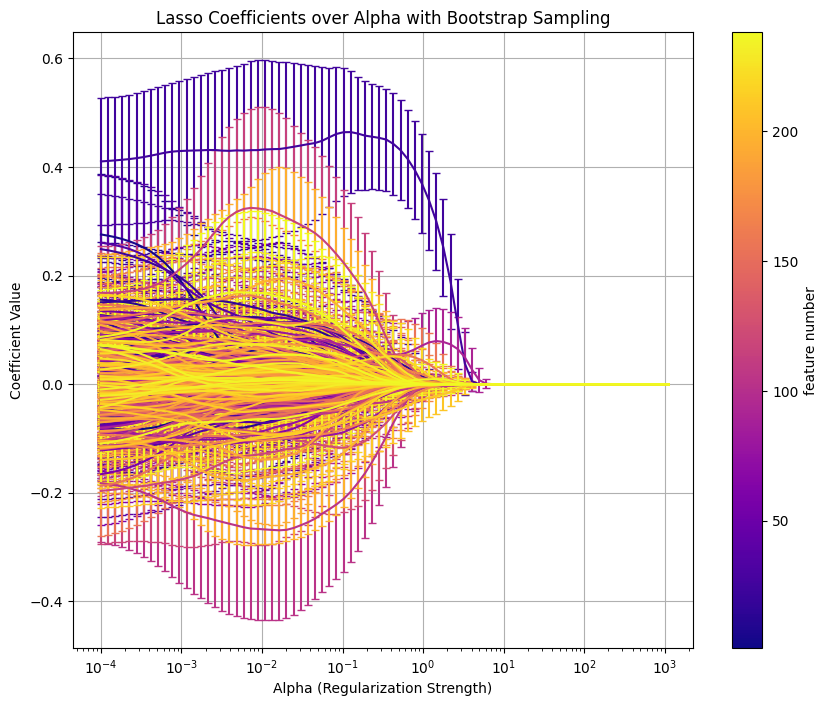

In [16]:
# Visualizing the coefficient matrix in a different cell to not have to rerun bootstrap every time. 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

# Obtaining the mean and std of each of the coefficients reducing the bootstrap dimension 
coeff_mean = np.mean(coefficients_matrix, axis=0)
coeff_std = np.std(coefficients_matrix, axis=0)

cmap = cm.get_cmap('plasma', gene_expression.shape[1])
norm = colors.Normalize(vmin=1,vmax=gene_expression.shape[1])

plt.figure(figsize=(10, 8))
for feature_idx in range(gene_expression.shape[1]):
    plt.errorbar(alpha_vals, coeff_mean[:, feature_idx], yerr=coeff_std[:, feature_idx],
                 label=f'Feature {feature_idx + 1}', capsize=3, color=cmap(feature_idx))
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature number') 
plt.title('Lasso Coefficients over Alpha with Bootstrap Sampling')
plt.grid(True)
plt.show()

C:\Users\20182717\AppData\Local\Temp\ipykernel_16036\1050146777.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature');


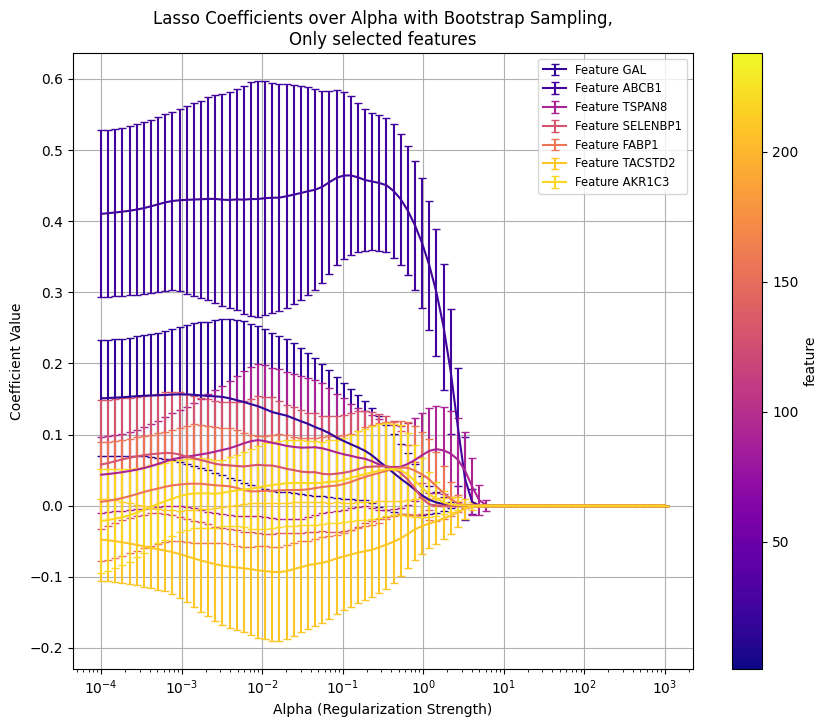

In [21]:
plt.figure(figsize=(10, 8))
for feature_idx in range(gene_expression.shape[1]):
    if feature_idx in selected_features:
        plt.errorbar(alpha_vals, coeff_mean[:, feature_idx], yerr=coeff_std[:, feature_idx],
                 label=f'Feature {gene_expression.columns[feature_idx]}', capsize=3, color=cmap(feature_idx))
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature')
plt.title('Lasso Coefficients over Alpha with Bootstrap Sampling,\nOnly selected features')
plt.legend(loc='best', fontsize='small')
plt.grid(True)

Answer:

As the regularization coefficient increases we see more and more of the coefficients reduced to zero. This means that as alpha increases our model complexity decreases as well. A more complex model usually has less bias but higher variance, thus meaning with a higher alpha we obtain less bias but higher variance and with a lower alpha we obtain more bias but less variance.


## Logistic regression

<p><font color='#770a0a'>Write the expression of the objective function for the penalized logistic regression with $L_1$ and $L_2$ regularisation (as in Elastic net).</font></p>

The expression for the objective of elastic net in logistic regression is:

$L(\beta) = -(\frac{1}{n} * \sum _{i=1}^n[y_i * log(p_i) + (1- y_i)*log(1-p_i)]) + \alpha * (\frac{1-\rho}{2}\sum^p_{j=1} \beta _j^2 + \rho \sum ^p _{j=1}|\beta _j|) $

Here the expression consists of two main parts, the objective function and the elastic net regularization:

The objective function consists of a sum over all samples where we take the average of n samples over two parts:

The left part 'activates' when the true label is 1 and equates the log of p_i which is the prediction of the logistic regression ($p_i=\frac{1}{1+exp(X_i\beta)}$)

The right part represents the probability of log(1-p_i) only when the true lable is 0

Then we have the regularization part of the elastic net formula:

We have two hyperparamters which are alpha corresponding the strength of the regularization and a new hyperparameter rho representing the ratio between L1 and L2 regularization. 

Then again we have a left part representing L2 regularization in beta squared which helps against large coefficients reducing overfitting. 

And we have right part representing L1 regularization shrinking small coefficients 